Steps 
1. Characterize the data 
2. 


In [ ]:
pip install scikit-learn


In [4]:
# Import libraries 
import pandas as pd
# import files as fl
import numpy as np
import wget as wget
import matplotlib.pyplot as plt 
# import geopandas as gpd
# import rasterio as rs 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from joblib import dump, load

In [5]:
# Read the dataset 
df_path = "df_for_analysis_ESS569.csv"
df_orig = pd.read_csv(df_path)

# Check data frame shape
df_shape = df_orig.shape

# Extract the number of rows and columns
num_rows, num_columns = df_shape

# Print the dimensions
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

# Number of rows: 1825
# Number of columns: 29


Number of rows: 1825
Number of columns: 29


In [33]:
# Clean-up the dataset 

# Remove coordinates and unwnated columns from df_orig 
df = df_orig.drop(columns=['X', 'Y', 'Unnamed: 0'])

# Print column names 
column_names = df.columns

# Print the column names along with their index positions
print("Column Names and Index Positions:")
for i, column_name in enumerate(column_names):
    print(f"Column {i}: {column_name}")

# Check NAs
columns_with_nans = df.columns[df.isna().any()].tolist()

if columns_with_nans:
    print("Columns with NA values:", columns_with_nans)
else:
    print("No NA values in any column.")

# No NA values in any column


Column Names and Index Positions:
Column 0: RBR
Column 1: AET_1981_2010
Column 2: dist_streams_wetlands
Column 3: ESI
Column 4: FRS
Column 5: T_max_bpd
Column 6: pct_canopy_cover
Column 7: canopy_rumple
Column 8: pctl_25_canopy_height
Column 9: pctl_95_canopy_height
Column 10: Pct_1_tree_clumps
Column 11: Pct_2_4_tree_clumps
Column 12: Pct_5_9_tree_clumps
Column 13: Pct_gteq10_tree_clumps
Column 14: topo_aspect
Column 15: topo_curvature_45
Column 16: topo_plan_curvature
Column 17: topo_slope_135
Column 18: topo_SRI
Column 19: topo_SRI_270
Column 20: topo_TPI_4000
Column 21: topo_TPI_500
Column 22: SCF
Column 23: wind_northsouthness
Column 24: Rx
Column 25: EVT_PP
No NA values in any column.


In [ ]:
# Random forests regeression model 

# Define predictor features (X) and target variable (y)
X = df.drop(columns=['RBR'])  # 'RBR' is the target variable
y = df['RBR']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Hyperparameter Tuning (Number of Trees, Maximum Depth, Minimum Samples per Leaf, and Number of Predictors)
param_grid = {
    'n_estimators': [200, 300, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40],  # Maximum depth of each tree
    'min_samples_leaf': [5, 10 ,15 ,20],  # Minimum samples per leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of predictors to consider at each split
    'bootstrap': [True],
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs= 6) # n_jobs specifies the number of CPU cores to use for parallel computation 
grid_search.fit(X_train, y_train)

# Save the GridSearchCV object to a file
dump(grid_search, 'grid_search_model.joblib')

In [21]:
# Load the GridSearchCV object from the file
# loaded_grid_search = load('grid_search_model.joblib')
# grid_search = loaded_grid_search

In [22]:
# Step 2: Cross-Validation
best_rf = grid_search.best_estimator_
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=10, scoring='r2')
avg_cv_r2 = np.mean(cv_scores)

# Step 3: Print Best Hyperparameters
print("Best Hyperparameters:")
print(grid_search.best_params_)

# Save the best_rf object to a file
# dump(best_rf, 'best_rf.joblib')

# Best Hyperparameters:
# {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 5, 'n_estimators': 500}

Best Hyperparameters:
{'max_depth': 20, 'max_features': None, 'min_samples_leaf': 5, 'n_estimators': 500}


In [25]:
# Step 4: Fit the Random Forest Regression Model
best_rf.fit(X_train, y_train)

# Step 5: Evaluate the Model (R-squared and RMSE) on Train and Test Data
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"R-squared (Train): {r2_train:.4f}")
print(f"RMSE (Train): {rmse_train:.4f}")
print(f"R-squared (Test): {r2_test:.4f}")
print(f"RMSE (Test): {rmse_test:.4f}")

# R-squared (Train): 0.8568
# RMSE (Train): 48.8182
# R-squared (Test): 0.6403
# RMSE (Test): 74.0406

R-squared (Train): 0.8568
RMSE (Train): 48.8182
R-squared (Test): 0.6403
RMSE (Test): 74.0406


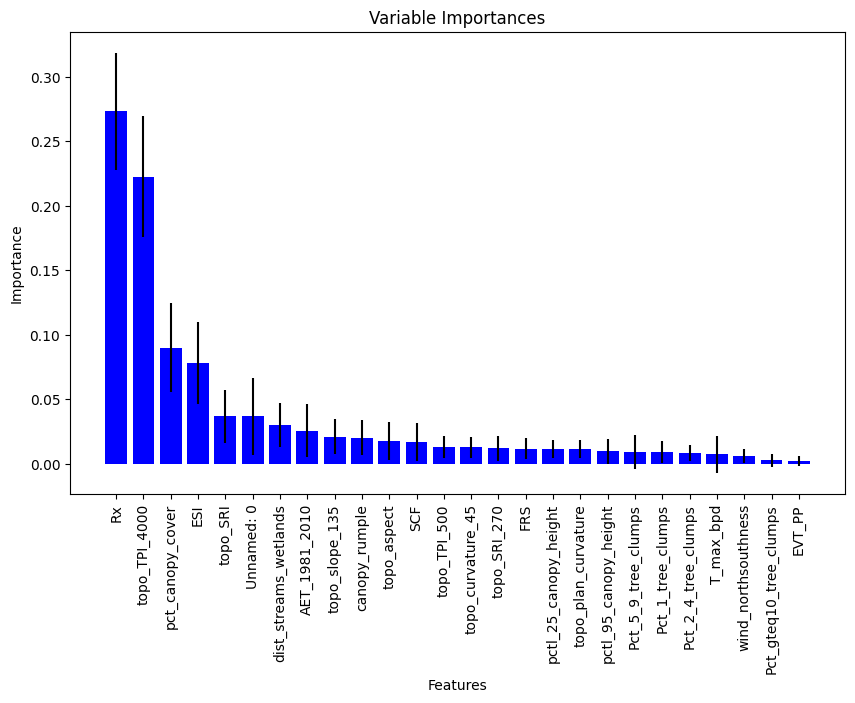

In [26]:
# Step 6: Plot Variable Importances based on Gini Impurity 
importances = best_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Variable Importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="b", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

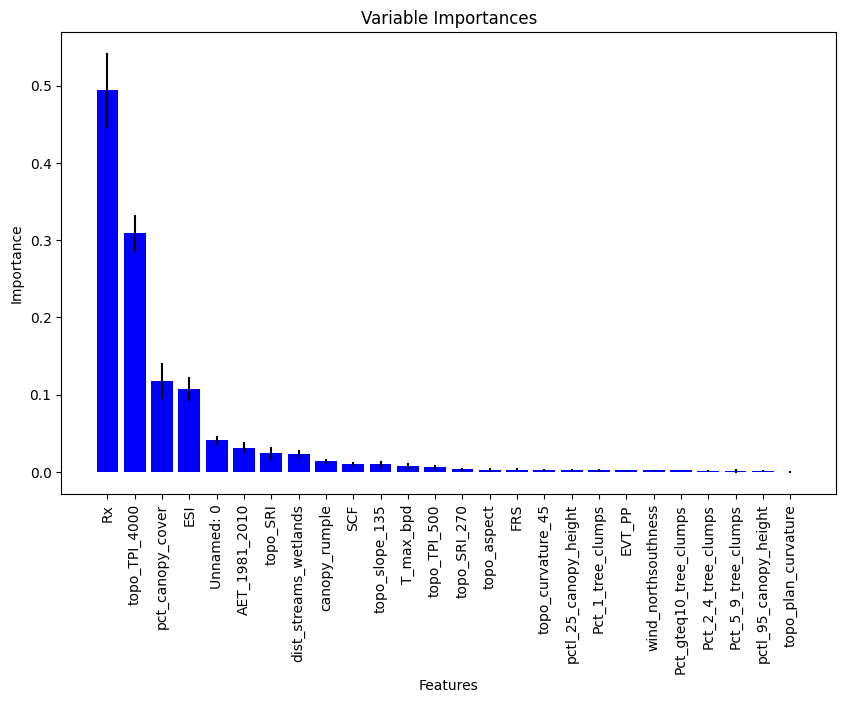

In [27]:

# Step 6: Plot Variable Importances based on Permutation
# Calculate permutation importances
result = permutation_importance(best_rf, X_test, y_test, n_repeats=30, random_state=0)  # Use X_test and y_test

importances = result.importances_mean
std = result.importances_std
indices = np.argsort(importances)[::-1]

# Visualization
plt.figure(figsize=(10, 6))
plt.title("Variable Importances")
plt.bar(range(X_test.shape[1]), importances[indices], color="b", yerr=std[indices], align="center")
plt.xticks(range(X_test.shape[1]), X_test.columns[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()


In [ ]:
## Second run including feature elimination before fitting the model on the test dataset 

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Define predictor features (X) and target variable (y)
X = df.drop(columns=['RBR'])  # 'RBR' is the target variable
y = df['RBR']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Hyperparameter Tuning (Number of Trees, Maximum Depth, Minimum Samples per Leaf, and Number of Predictors)
param_grid = {
    'n_estimators': [200, 300, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40],  # Maximum depth of each tree
    'min_samples_leaf': [5, 10, 15, 20],  # Minimum samples per leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of predictors to consider at each split
    'bootstrap': [True],
}

rf = RandomForestRegressor(random_state=42)

# Step 2: Hyperparameter tuning (GridSearchCV)
grid_search = GridSearchCV(rf, param_grid, cv=10, scoring='r2', n_jobs=6)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_rf = grid_search.best_estimator_

# Step 3: Feature selection using RFECV
rfecv = RFECV(estimator=best_rf, step=1, cv=10, scoring='r2')
rfecv.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

# Subset your data to include only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Step 4: Fit the Random Forest Regression Model
final_rf = RandomForestRegressor(random_state=42, **grid_search.best_params_) # ** =  dictionary unpacking
final_rf.fit(X_train_selected, y_train)

# Step 5: Evaluate the Model (R-squared and RMSE) on Train and Test Data
y_train_pred = final_rf.predict(X_train_selected)
y_test_pred = final_rf.predict(X_test_selected)

r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Selected Features: {selected_features}")
print("Best Hyperparameters:")
print(grid_search.best_params_)
print(f"R-squared (Train): {r2_train:.4f}")
print(f"RMSE (Train): {rmse_train:.4f}")
print(f"R-squared (Test): {r2_test:.4f}")
print(f"RMSE (Test): {rmse_test:.4f}")

# Save the GridSearchCV object to a file
dump(grid_search, 'grid_search_model.joblib')

# Save the best_rf object to a file
dump(best_rf, 'best_rf.joblib')

# Save the final_rf object to a file
dump(final_rf, 'final_rf.joblib')

# Save the selected features
dump(selected_features, 'selected_features.joblib')

